# Phase 2

### Disclaimer

*Our research focus/question changed drastically during the phase 2 process. We did some initial cleaning and analysis on our preliminary data, but eventually decided to refocus our attention. We had some data on renewable energy generation in the US that we were planning on using simply to contextualize our initial question, which dealt primarily with placement of windmills so as to generate the most amount of energy while also being considerate of other social, environmental, and economic factors. As we progressed in our research, however, we decided that refocusing our question would require more data on energy usage and production (and via what source), so we went looking for better datasets. While we did find better datasets eventually and we understand that this is simply part of the process, we wanted to acknowledge some of the work that did go into phase 2 but which will, more likely than not, be scrapped in the final phase of this project. As such, we keep that preliminary work in this notebook, but we are sure to note explicitely which datasets we will probably not be using in future.*

<a id=’introduction’></a>
## Introduction

Introduction goes here 

### Research Question:

research question here

<a id=’section_1’></a>
## Dataset Description 

Data description goes here

## Data Limitations

limitations here 

## Data Cleaning Description

Here, we clean the datasets mentioned in [Dataset Description](#section_1) above, and we also explain this process in detail.  

### Loading Data

In [38]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import duckdb, sqlalchemy

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
#please see above for description of these datasets
ref_df = pd.read_csv("reference.csv")
consumption_df = pd.read_csv("consumption.csv")
production_df = pd.read_csv("production.csv")

#this dataset will most likely not be used in final
us_total_df = pd.read_csv("total_renewable.csv")

### Cleaning Data

**ref_df:** First, ref_df is already pretty much clean. It contains appropriate column titles and all the criterion that we plan on using in identifying ideal windmill placement. We first check the dtypes to ensure that all columns contain float values that we could easily analyze. We also not that the column "Unnamed: 0" is simply an identifier that the data collectors used for the separate places that will not serve any purpose in our analysis, so we drop that column. 

Finally, we show first 5 rows of the cleaned ref_df.

In [3]:
#check ref_df dtypes
print(ref_df.dtypes)

#drop unneeded first column
ref_df = ref_df.drop('Unnamed: 0', axis = 1)

#show first 5 columns of cleaned dataset
ref_df.head()

Unnamed: 0                       int64
latitude                       float64
longitude                      float64
area_sq_km                     float64
capacity_mw                    float64
generation_mwh                 float64
capacity_factor                float64
wind_speed_120meters           float64
distance_to_transmission_km    float64
dtype: object


,latitude,longitude,area_sq_km,capacity_mw,generation_mwh,capacity_factor,wind_speed_120meters,distance_to_transmission_km
0,38.668999,-90.156998,0.5427,1.6281,5217.820421,0.365851,6.752910,0.041277
1,45.380001,-92.155998,8.6184,25.8552,97673.112905,0.431244,7.488254,0.055366
2,47.574001,-95.418999,13.9968,41.9904,174115.603258,0.473351,8.025779,0.076005
3,38.020000,-100.928001,23.4252,70.2756,285496.416362,0.463759,8.148561,0.104679
4,41.917000,-96.801003,30.2292,90.6876,373754.694846,0.470473,7.991315,0.132139


**consumption_df and production_df:** For consumption_df and production_df, we did a sql INNER JOIN to make working with the data easier by just having to reference one dataset instead of 2. The column 'Month' for consumption_df and production_df contain the same information so we join on that key and delete duplicates (we got a duplicate for the column 'Month'). The 'Month' column is renamed 'date' since it contains more information than just the month. We then make the 'date' column a datetime object so as to make analysis easier later on. We additionally add a month and year column to our new dataframe as later on, we may want to focus on certain years and/or months. 

We also check the dtypes attribute of this new dataframe, named *total_df* so as to continue cleaning. 

In [4]:
#renaming column 'Month'
production_df = production_df.rename(columns={"Month": "date"})

#inner join 
%sql total_df << SELECT * FROM production_df INNER JOIN consumption_df ON production_df.date = consumption_df.Month  

#delete duplicate
total_df = total_df.drop('Month', axis = 1)

#change 'date' to datetime
total_df['date'] = pd.to_datetime(total_df['date'], format = "%Y %B")

#add month and year columns
total_df['year'] = pd.DatetimeIndex(total_df['date']).year
total_df['month'] = pd.DatetimeIndex(total_df['date']).month

#check dataframe dtypes attribute
print(total_df.dtypes)

Returning data to local variable total_df
date                                                              datetime64[ns]
Coal Production                                                          float64
Natural Gas (Dry) Production                                             float64
Crude Oil Production                                                     float64
Natural Gas Plant Liquids Production                                     float64
Total Fossil Fuels Production                                            float64
Nuclear Electric Power Production                                        float64
Hydroelectric Power Production                                           float64
Geothermal Energy Production                                             float64
Solar Energy Production                                                   object
Wind Energy Production                                                    object
Biomass Energy Production                                          

We note that when checking the dtypes of the dataframe that there are several columns with dtype object, and this is since there are cells with the value 'Not Available.' To prevent difficulty when trying to analyze this data, we change all columns but the date column to float64 and assign NaN (not a number) values to those cells which contain string values, as follows:

In [5]:
#making column values float64 where applicable 
cols = total_df.columns.values  
for i in range(1,26):
    name = cols[i]
    total_df[name] = pd.to_numeric(total_df[name], errors = 'coerce')

Finally, we show first 5 rows of the cleaned total_df.

In [6]:
total_df.head()

,date,Coal Production,Natural Gas (Dry) Production,Crude Oil Production,Natural Gas Plant Liquids Production,Total Fossil Fuels Production,Nuclear Electric Power Production,Hydroelectric Power Production,Geothermal Energy Production,Solar Energy Production,...,Nuclear Electric Power Consumption,Hydroelectric Power Consumption,Geothermal Energy Consumption,Solar Energy Consumption,Wind Energy Consumption,Biomass Energy Consumption,Total Renewable Energy Consumption,Total Primary Energy Consumption,year,month
0,1973-01-01,1.166486,1.908249,1.649833,0.208064,4.932632,0.068103,0.272703,0.001491,NaN,...,0.068103,0.272703,0.001491,NaN,NaN,0.129787,0.403981,7.223873,1973,1
1,1973-02-01,1.086072,1.922543,1.525783,0.195184,4.729582,0.064634,0.242199,0.001363,NaN,...,0.064634,0.242199,0.001363,NaN,NaN,0.117338,0.360900,6.592366,1973,2
2,1973-03-01,1.196571,1.868430,1.667094,0.214807,4.946902,0.072494,0.268810,0.001412,NaN,...,0.072494,0.268810,0.001412,NaN,NaN,0.129938,0.400161,6.521439,1973,3
3,1973-04-01,1.112230,1.777561,1.616791,0.209690,4.716271,0.064070,0.253185,0.001649,NaN,...,0.064070,0.253185,0.001649,NaN,NaN,0.125636,0.380470,5.941729,1973,4
4,1973-05-01,1.216978,1.859241,1.665377,0.215398,4.956995,0.062111,0.260770,0.001537,NaN,...,0.062111,0.260770,0.001537,NaN,NaN,0.129834,0.392141,6.071940,1973,5


**us_total_df:**
*We will most likely not be using this dataset, but since we cleaned and it made some plots of the data, we show that work here.*

This dataframe is very messy upon first looking at it. The first 5 rows are shown below for reference. There are unneccessary columns and the titles are contained within a row of the dataframe. There is also a row which does not contain any values within it.

In [7]:
us_total_df.head()

Renewable Electricity generation (GWh) by Region/country/area, Technology and Year
Region/country/area Technology             2000      2001      2002      2003      2004      2005      2006      2007      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019                                                    2020                                
USA                 Total renewable energy 330364.00 260426.00 348137.00 360433.00 357987.00 366205.00 395209.00 361815.00 391023.00 428696.00 440677.00 528962.00 512822.00 541802.00 560657.00 568439.00 637076.01 718174.01 743177.01 767035.01                                          827387.01                                
                    Hydropower             279986.00 214728.00 291755.00 305724.00 297894.00 297926.00 317689.00 275545.00 281995.00 298410.00 286333.00 344561.00 298287.00 290113.00 281527.00 271129.00 292113.00 325114.00 317004.00 310571.00                                          308213.00                                
                    Renewable hydropower   253204.00 188252.00 267034.00 278609.00 271118.00 272445.00 291869.00 249619.00 256714.00 275590.00 262266.00 321733.00 278511.00 270856.00 261473.00 251018.00 269670.00 302362.00 295501.00 289799.00                                          287140.00                                
                    Pumped storage         26782.00  26476.00  24721.00  27115.00  26776.00  25481.00  25820.00  25926.00  25281.00  22820.00  24067.00  22828.00  19776.00  19257.00  20054.00  20111.00  22443.00  22752.00  21503.00  20772.00                                            21073.00

As such, we reset all the indices, take the first row and make it the column titles. We drop the row with no values in it, we drop the first column which does not seem to serve any purpose, and we transpose so that we can have years in one column so as to make analysis/plotting easier later on. We make sure every value within the table is a float, and we change the year column into datetime. 

Finally, the first 5 rows are displayed. 

In [8]:
us_total_df = us_total_df.reset_index(drop = False).drop(labels='level_0', axis=1)
index = us_total_df.iloc[0,:].squeeze()[:].reset_index(drop=True)

us_total_df.columns.values[::] = index
us_total_df = us_total_df.drop(0)
us_total_df = us_total_df.transpose().reset_index(drop = False)

index_2 = us_total_df.iloc[0,:].squeeze()[:].reset_index(drop=True)
us_total_df.columns.values[::] = index_2

us_total_df = us_total_df.drop(0)
us_total_df = us_total_df.rename(columns={'Technology': 'Year'}).drop(labels= 'Bagasse', axis = 1)

cols = us_total_df.columns
us_total_df[cols[1:]] = us_total_df[cols[1:]].astype(float)

us_total_df['Year'] = pd.to_datetime(us_total_df['Year'], format = "%Y")
us_total_df['Year'] = pd.DatetimeIndex(us_total_df['Year']).year

us_total_df.head()

,Year,Total renewable energy,Hydropower,Renewable hydropower,Pumped storage,Marine,Wind,Onshore wind energy,Offshore wind energy,Solar,Solar photovoltaic,Concentrated solar power,Bioenergy,Solid biofuels,Renewable municipal waste,Other solid biofuels,Liquid biofuels,Biogas,Geothermal
1,2000,330364.0,279986.0,253204.0,26782.0,0.0,5650.0,5650.0,0.0,709.0,183.0,526.0,56180.0,50950.0,8364.0,42586.0,0.0,5230.0,14621.0
2,2001,260426.0,214728.0,188252.0,26476.0,0.0,6806.0,6806.0,0.0,785.0,220.0,565.0,50337.0,44923.0,8102.0,36821.0,0.0,5414.0,14246.0
3,2002,348137.0,291755.0,267034.0,24721.0,0.0,10459.0,10459.0,0.0,830.0,261.0,569.0,54875.0,48462.0,8252.0,40210.0,852.0,5561.0,14939.0
4,2003,360433.0,305724.0,278609.0,27115.0,0.0,11300.0,11300.0,0.0,848.0,300.0,548.0,54806.0,47804.0,8093.0,39711.0,685.0,6317.0,14870.0
5,2004,357987.0,297894.0,271118.0,26776.0,0.0,14291.0,14291.0,0.0,965.0,378.0,587.0,56126.0,49371.0,8939.0,40432.0,343.0,6412.0,15487.0


## Preliminary Analysis

### Concerning total_df

We wanted to build some context at the beginning of our work. As we note in our [Introduction](#introduction), while renewable energy production/consumption are on the rise, we wanted to see these trends over time. Here, we initially plot total fossil fuels production/consumption and total renewable energy production/consumption in the US. Note that the units are Quadrillion BTUs. (Note: we may make a function later so as to make the plotting easier if we wanteed to see a particular source and its trends over time. 

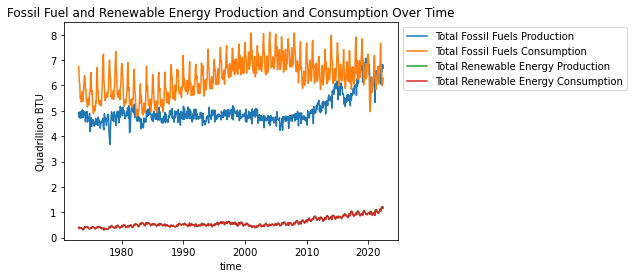

In [9]:
#plotting total fossil fuels production/consumption and total renewable energy production/consumption
sns.lineplot(data = total_df, x = 'date', y = 'Total Fossil Fuels Production', label = 'Total Fossil Fuels Production')
sns.lineplot(data = total_df, x = 'date', y = 'Total Fossil Fuels Consumption', label = 'Total Fossil Fuels Consumption')
sns.lineplot(data = total_df, x = 'date', y = 'Total Renewable Energy Production', label = 'Total Renewable Energy Production')
sns.lineplot(data = total_df, x = 'date', y = 'Total Renewable Energy Consumption', label = 'Total Renewable Energy Consumption')

plt.title("Fossil Fuel and Renewable Energy Production and Consumption Over Time")
plt.xlabel("time")
plt.ylabel("Quadrillion BTU")
 
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

Here, we see that total renewable energy production/consumption is about equal. We note that fossil fuel consumption is higher than production usually. We also observe that while renewable energy production has been on the rise, fossil fuel production has not necessarily been on a decline. The next two plots make this clearer. We plot total renewable energy production over time, and we plot the curve of wind energy production as well to show an initial visualization how much of that renewable energy production comes form wind energy. We also plot simply the rise in total fossil fuels production alone over the years. 

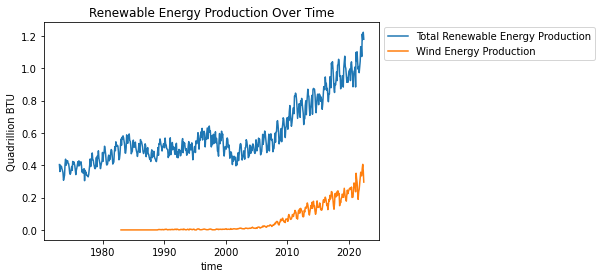

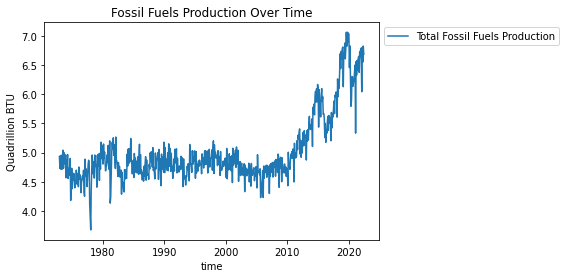

In [10]:
#plotting total renewable energy production as well as wind energy production curve
sns.lineplot(data = total_df, x = 'date', y = 'Total Renewable Energy Production', label = 'Total Renewable Energy Production')
sns.lineplot(data = total_df, x = 'date', y = 'Wind Energy Production', label = 'Wind Energy Production')
plt.title("Renewable Energy Production Over Time")
plt.xlabel("time")
plt.ylabel("Quadrillion BTU")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

#plotting total fossil fuels production alone over the years
sns.lineplot(data = total_df, x = 'date', y = 'Total Fossil Fuels Production', label = 'Total Fossil Fuels Production')
plt.title("Fossil Fuels Production Over Time")
plt.xlabel("time")
plt.ylabel("Quadrillion BTU")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

To make clearer again this large dependence on fossil fuels, we make a pie chart of the most recent year's energy production by type. First, we create a new dataframe containing only data from 2022 and we take the mean of each individual energy type.

Returning data to local variable energy_2022


<function matplotlib.pyplot.show(close=None, block=None)>

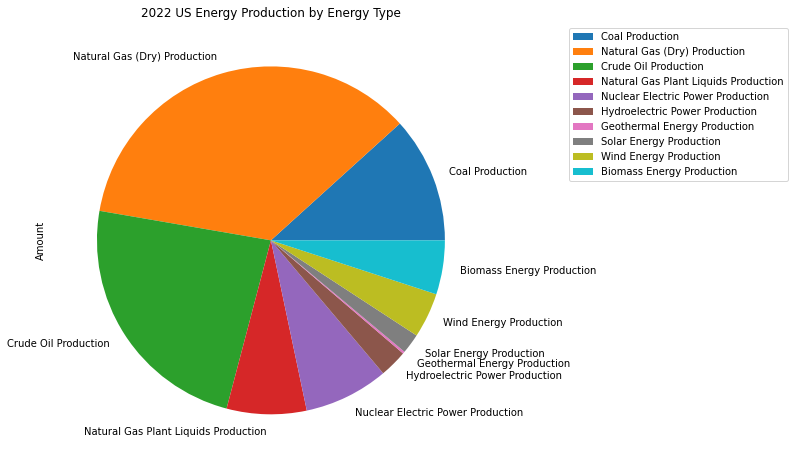

In [11]:
# make a pie chart for 2022 so far 
%sql energy_2022 << SELECT * FROM total_df WHERE year = 2022
col = energy_2022.columns
avg_production = pd.DataFrame(energy_2022[col[1:12]].mean(axis=0))
avg_production = avg_production.rename(columns={ 0 : "Amount"}).drop('Total Fossil Fuels Production')
                                                                    
avg_production.plot.pie(y='Amount', figsize=(8, 8))
plt.legend(bbox_to_anchor=(1.7, 1.0))
plt.title("2022 US Energy Production by Energy Type")
plt.show

We note that the these curves over time look logistic. For this preliminary analysis, let us simply see total renewable energy production over the years (so we take the average to find annual renewable energy production).

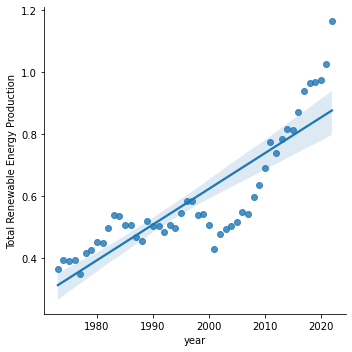

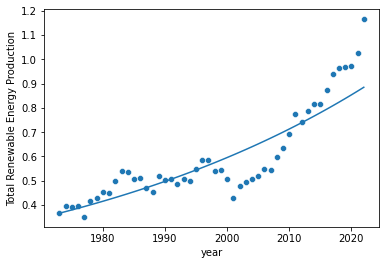

In [54]:
annual_df = total_df.iloc[:, [12, 26]].groupby(['year']).mean('Total Renewable Energy Production').reset_index()
annual_df

x = annual_df['year']
y = annual_df['Total Renewable Energy Production']

sns.lmplot(data = annual_df, x = 'year', y = 'Total Renewable Energy Production')
plt.show()

exp = np.polyfit(x, np.log(y), 1)
a = np.exp(exp[1])
b = exp[0]
x_new = np.linspace(np.min(x), np.max(x))
y_new = a * np.exp(b * x_new)

sns.scatterplot(data=annual_df, x= x, y= y)
plt.plot(x_new, y_new)
plt.show()